In [1]:
import os
from skimage.metrics import structural_similarity as ssim
from skimage.transform import resize
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
from img_compare import *

# Introduction

This is a showcase of some image comparison functions and how I use them to try and group Reddit memes together to identify popular meme formats.

I will be using three different image comparison metrics to determine similarity: Mean Squared Error (MSE), Structural Similarity Measure (SSIM), and image hashing.

### Mean Squared Error (MSE)

The Mean Squared Error (MSE) between the two images is the sum of the squared difference between the two images.

It's pretty simple to implement, but it is a decent measure of similarity. It only functions on images of the same size.

MSE has some limitations. For example, large distances between pixel intensities, such as contrasted images, do not necessarily mean the image is not similar.

Note that lower MSEs mean more similar images.

### Structural Similarity Measure (SSIM)

The Structural Similarity Measure (SSIM). SSIM attempts to model the perceived change in the structural information of the image.

Essentially, the main benefit of SSIM is that it accounts for texture. It measures similarity, just as MSE, but takes into account image quality.

SSIM is likely the strictest of the three measures used to indicate image similarity.

Note that higher SSIMs reflect more similarity.

### Image Hashing

Image hashing or perceptual hashing is the process of examining the contents of an image and then constructing a hash value that uniquely identifies an input image based on the contents of the image.

Essentially, it narrows the image down to a set of unique features and assigns it a value based on those features.

The image hashes of two similar images will be more similar than the image hashes of two different images. Therefore, by subtracting the image hashes, one can get a rough measure of how similar two images are.

Note that a lower hash difference means the images are more similar.

# Examples

Let's see some example images and how they compare using our similarity measures.

Run the following block to see all available test images:

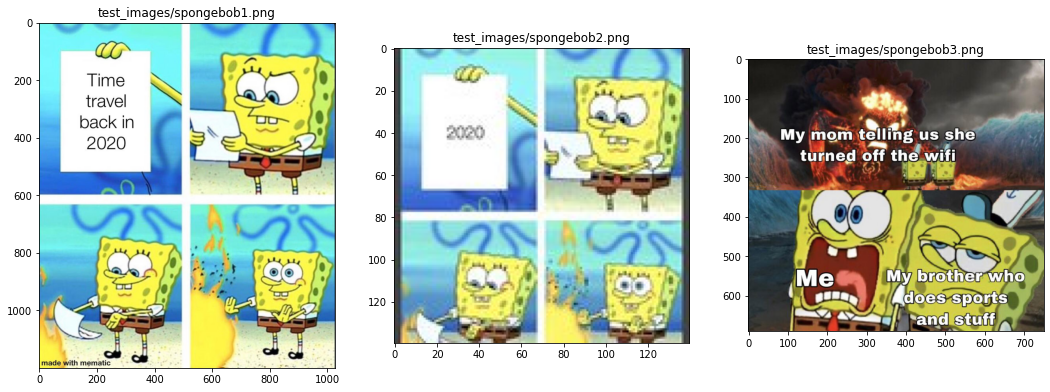

In [7]:
test_image_paths = img_folder_plot(TEST_IMG_PATH)
imgA = cv2.imread(test_image_paths[0])
imgB = cv2.imread(test_image_paths[1])
imgC = cv2.imread(test_image_paths[2])

Let's compare spongebob1.png and spongebob2.png, two memes with the same meme format, but sized differently and with different qualities.

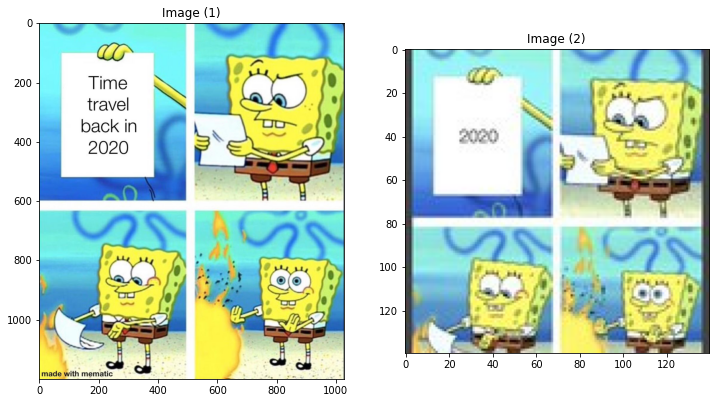

MSE: 0.07560973075958617
SSIM: 0.6437364351044425
HASH: 23


(0.07560973075958617, 0.6437364351044425, 23)

In [4]:
compare_images(imgA, imgB, visualize=True)

Now, let's compare spongebob1.png and spongebob3.png, two memes with completely different meme formats (although both feature spongebob)

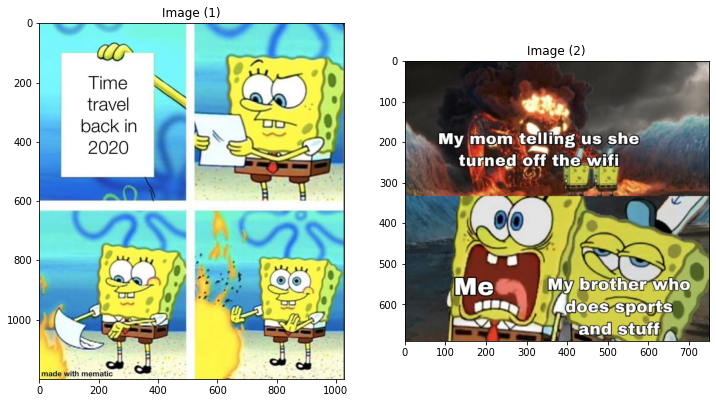

MSE: 0.23747421165086122
SSIM: 0.4032295038558613
HASH: 32


(0.23747421165086122, 0.4032295038558613, 32)

In [5]:
compare_images(imgA, imgC, visualize=True)

Finally, let's compare spongebob2.png and spongebob3.png, which also have completely different meme formats.

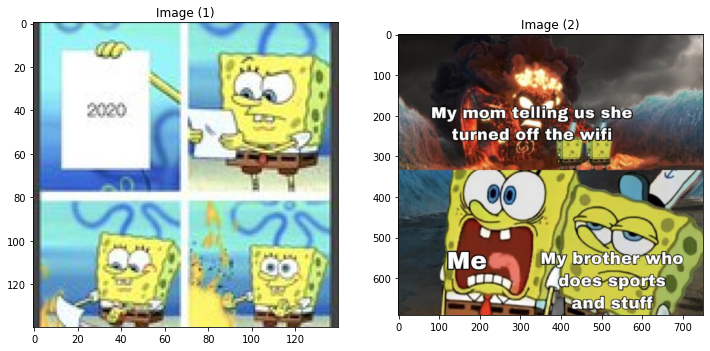

MSE: 0.228390133086145
SSIM: 0.35620894495679245
HASH: 35


(0.228390133086145, 0.35620894495679245, 35)

In [6]:
compare_images(imgB, imgC, visualize=True)

As can be seen the two images with the same meme format have lower MSEs, higher SSIMs, and lower hash differences than images with different meme formats.

Although, the scores may still be a bit off from what you may have expected.

For example, why do the images with the same meme format still have such a low SSIM and such a high hash?

It's important to remember SSIM measures texture, making it perhaps the strictest of the three measures. Memes come in many different qualities, so SSIM, while still showing similarity, will be harsher towards different quality images.

Hashes are used to compare when images are nearly identical. Not just the different quality but the different text affects how well hashes work, although of course they still reflect the similarity of the two images.

SSIM and Hashes are both stricter metrics than MSE. Although, they are both still important. For example, SSIM will be more resistant to contrasting a meme format (a common practice) relative to MSE.